## Imports

In [1]:
import torch
import matplotlib.pyplot as plt

from protxlstm.applications.fitness_prediction import single_mutation_landscape_xlstm, create_mutation_df
from protxlstm.applications.msa_sampler import sample_msa
from protxlstm.models.xlstm import xLSTMLMHeadModel
from protxlstm.utils import load_sequences_from_msa_file, load_model, ID_TO_AA

/system/apps/userenv/schnecke/prot_xlstm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

Please provide the path to your Prot-xLSTM model:

In [2]:
checkpoint = "../checkpoints/protxlstm_102M_60B"

Provide your target sequence:

In [3]:
target_sequence = "MTARGLALGLLLLLLCPAQVFSQSCVWYGECGIAYGDKRYNCEYSGPPKPLPKDGYDLVQELCPGFFFGNVSLCCDVRQLQTLKDNLQLPLQFLSRCPSCFYNLLNLFCELTCSPRQSQFLNVTATEDYVDPVTNQTKTNVKELQYYVGQSFANAMYNACRDVEAPSSNDKALGLLCGKDADACNATNWIEYMFNKDNGQAPFTITPVFSDFPVHGMEPMNNATKGCDESVDEVTAPCSCQDCSIVCGPKPQPPPPPAPWTILGLDAMYVIMWITYMAFLLVFFGAFFAVWCYRKRYFVSEYTPIDSNIAFSVNASDKGEASCCDPVSAAFEGCLRRLFTRWGSFCVRNPGCVIFFSLVFITACSSGLVFVRVTTNPVDLWSAPSSQARLEKEYFDQHFGPFFRTEQLIIRAPLTDKHIYQPYPSGADVPFGPPLDIQILHQVLDLQIAIENITASYDNETVTLQDICLAPLSPYNTNCTILSVLNYFQNSHSVLDHKKGDDFFVYADYHTHFLYCVRAPASLNDTSLLHDPCLGTFGGPVFPWLVLGGYDDQNYNNATALVITFPVNNYYNDTEKLQRAQAWEKEFINFVKNYKNPNLTISFTAERSIEDELNRESDSDVFTVVISYAIMFLYISLALGHMKSCRRLLVDSKVSLGIAGILIVLSSVACSLGVFSYIGLPLTLIVIEVIPFLVLAVGVDNIFILVQAYQRDERLQGETLDQQLGRVLGEVAPSMFLSSFSETVAFFLGALSVMPAVHTFSLFAGLAVFIDFLLQITCFVSLLGLDIKRQEKNRLDIFCCVRGAEDGTSVQASESCLFRFFKNSYSPLLLKDWMRPIVIAIFVGVLSFSIAVLNKVDIGLDQSLSMPDDSYMVDYFKSISQYLHAGPPVYFVLEEGHDYTSSKGQNMVCGGMGCNNDSLVQQIFNAAQLDNYTRIGFAPSSWIDDYFDWVKPQSSCCRVDNITDQFCNASVVDPACVRCRPLTPEGKQRPQGGDFMRFLPMFLSDNPNPKCGKGGHAAYSSAVNILLGHGTRVGATYFMTYHTVLQTSADFIDALKKARLIASNVTETMGINGSAYRVFPYSVFYVFYEQYLTIIDDTIFNLGVSLGAIFLVTMVLLGCELWSAVIMCATIAMVLVNMFGVMWLWGISLNAVSLVNLVMSCGISVEFCSHITRAFTVSMKGSRVERAEEALAHMGSSVFSGITLTKFGGIVVLAFAKSQIFQIFYFRMYLAMVLLGATHGLIFLPVLLSYIGPSVNKAKSCATEERYKGTERERLLNF"

Set the position in the target which you want to mutate:

In [4]:
mutation_positions = [5, 10] # Remark: indexing based 1

Define your context sequences either by providing a path to an MSA file or by entering a list of protein sequences:

In [5]:
msa_path = "./example_msas/NPC1_HUMAN.a3m"

Set the number of sequences to sample as context and the maximum number of context tokens. In number of context sequences is set to -1, all sequences are used (within the limit of the maximum number of context tokens):

In [6]:
num_context_sequences = 200
num_context_tokens = 2**15

Set your device:

In [7]:
device = "cuda:0"

## Prepare Context and Target sequences

Create a dataframe with all single mutations:

In [8]:
df_mutations = create_mutation_df(target_sequence, mutation_positions)

Retrieve context sequences:

In [9]:
if msa_path is not None and num_context_sequences != 0:
    msa_sequences = [msa.upper() for msa in load_sequences_from_msa_file(msa_path)]
    context_sequences = sample_msa(msa_sequences, max_context_sequences=num_context_sequences, context_length=num_context_tokens) + [target_sequence]

else:
    context_sequences = [target_sequence]

print(f'Number of context sequences: {len(context_sequences)} ({len(context_sequences)*len(context_sequences[0]):,} tokens)')

Number of context sequences: 25 (31,950 tokens)


## Load the model

In [10]:
# load the model

config_update_kwargs = {
                "mlstm_backend": "chunkwise_variable",
                "mlstm_chunksize": 1024,
                "mlstm_return_last_state": True}

model = load_model(
    checkpoint,
    model_class=xLSTMLMHeadModel,
    device=device,
    dtype=torch.bfloat16,
    **config_update_kwargs,
    )
model = model.eval()

detected slstm_block
In newest xlstm


In [11]:
print(next(model.parameters()).device)

cuda:0


## Calculate mutation effects

In [12]:
df_mutations, _ = single_mutation_landscape_xlstm(model, df_mutations, context_sequences, chunk_chunk_size=2**15)  # chunk_chunk_size determines how many tokens of the context sequence are processed at once; the lower the less GPU memory is needed

Generating mutational landscape: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


In [13]:
display(df_mutations)

,mutation,position,mutation_idx,effect
0,G5L,4,4,-0.603041
1,G5A,4,5,-0.746890
2,G5G,4,6,0.000000
3,G5V,4,7,-0.581367
4,G5S,4,8,0.029412
5,G5E,4,9,-0.731810
6,G5R,4,10,-0.753650
7,G5T,4,11,-0.555499
8,G5I,4,12,-1.144047
9,G5D,4,13,-0.916602


## Visualization

Amino acids are sorted by their predicted log-likelihood for the mutated position. \
Positive values indicate that the amino acid is more likely than the wildtype and vice versa.

In [14]:
# mutation_position = input(f"For which of the mutated positions do you want to visualize the mutation effects (one of {mutation_positions})?")
mutation_position = 5

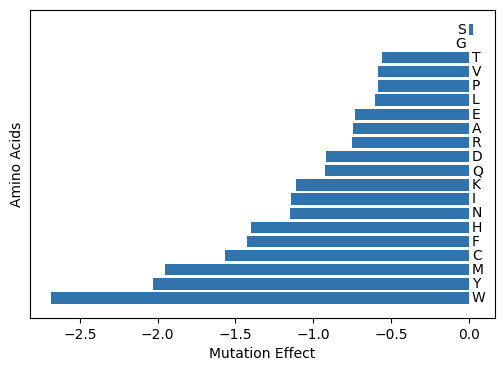

In [15]:
# Example data for the 20 amino acids and their scores at position 5
df_ = df_mutations[df_mutations.position == int(mutation_position)-1]
amino_acids = df_.mutation_idx.apply(lambda x : ID_TO_AA[x]).tolist()
scores = df_.effect.tolist()
# scores = list(mut_effects.cpu().numpy())

sorted_data = sorted(zip(scores, amino_acids), reverse=True)
scores, amino_acids = zip(*sorted_data)

# Create the bar chart
plt.figure(figsize=(6, 4))
bars = plt.barh(amino_acids, scores, color='#3073AD')
plt.xlabel('Mutation Effect')
plt.ylabel('Amino Acids')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()  # Invert y-axis to display highest scores at the top

# Annotate each bar with the amino acid letter
for bar, amino_acid in zip(bars, amino_acids):
    x = 0.02 if bar.get_width() < 0 else -0.02
    plt.text(x, bar.get_y() + bar.get_height() / 2, 
             amino_acid, ha='left' if bar.get_width() < 0 else 'right', 
             va='center', color='black', fontsize=10)

plt.show()